# GAF Take-Home Assessment

## Data Gathering & Exploratory Analysis

To get the data from Google Trends, I will use the Google Trends API to get weekly data for interest in "roof near me", and then aggregate by month and average the weekly interest scores to represent the monthly interest.

In [1]:
## import required packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
## load the dataset using Google Trends API
pytrend = TrendReq()
pytrend.build_payload(kw_list=['roof near me'])
df = pytrend.interest_over_time().reset_index()
df.tail(10)

,date,roof near me,isPartial
251,2020-08-30,86,False
252,2020-09-06,84,False
253,2020-09-13,84,False
254,2020-09-20,80,False
255,2020-09-27,80,False
256,2020-10-04,86,False
257,2020-10-11,79,False
258,2020-10-18,81,False
259,2020-10-25,76,False
260,2020-11-01,81,True


In [3]:
## check data types
df.dtypes

date            datetime64[ns]
roof near me             int64
isPartial               object
dtype: object

In [4]:
## isPartial means the interest score is estimated. Should only be true for the most recent week.
sum(df["isPartial"] == "True")

1

In [5]:
## create new features for year and month
df["year"] = df["date"].apply(lambda x: x.year)
df["month"] = df["date"].apply(lambda x: x.month)

## get yearly average interest score and standard deviation
df.groupby("year").agg({'roof near me': [np.mean, np.std]})

roof near me           
             mean        std
year                        
2015     9.750000   2.712405
2016    18.307692   5.054753
2017    30.849057   7.072145
2018    43.096154   8.146356
2019    56.730769   9.824171
2020    71.795455  16.109479

In [6]:
## find months with highest average interest scores

df.groupby(["month"]).agg({'roof near me': np.mean}).sort_values(by='roof near me', ascending=False)

,roof near me
month,
7,54.130435
8,53.571429
6,53.285714
9,50.500000
5,45.090909
10,45.045455
4,39.590909
3,37.681818
2,35.100000


### Initial Findings

Here are some initial findings about the dataset:

1. The feature "isPartial" indicates whether or not the interest score is an estimate, and is only "True" for the current week, since it hasn't ended yet. As this is a low-variance feature, we don't need it for modeling as it's not very informative.  
<br />
2. The yearly interest score for "roof near me" has strictly increased over the last 5 years.   
<br />
3. The variance in weekly interest score also strictly increased over the last 5 years.  
<br />
4. On average, the months with the highest interest scores are the months between May and October.

One important caveat is that for the year 2015, we only have information for November and December, so the mean and variance for 2015 should be taken with a grain of salt. That being said, the overall trend of increasing mean and variance holds true for 2016-2020.

## Feature Engineering

First, I will group the dataset by year and month, and then generate the following features to improve model performance:  

1. during_pandemic: a binary categorical variable indicating whether or not there was a global pandemic during the time period. This is useful because the trends reveal a clear spike in interest starting around the week of 3/22, which is around the time the lockdowns started in the US.  
<br />
2. season: a categorical variable indicating which season the time period falls in. Factoring seasonality may improve model performance if interest in roofs follows a seasonal trend (ex. higher during warmer seasons).  
<br />
3. may_to_oct: since the months between May and October were the months had notably higher interest scores, it's worth giving that month range its own indicator variable.

In [7]:
## drop isPartial, since it's "False" for all but one observation
df.drop(["isPartial"], axis=1, inplace=True)

## group data by month and year
monthly_data = df.groupby(["year", "month"]).agg({'roof near me': np.mean}).reset_index()

In [8]:
## create indicator for pandemic (starting March 2020)
def during_pandemic(year, month):
    if year == 2020 and month >=3:
        return(1)
    else:
        return(0)

monthly_data["during_pandemic"] = monthly_data.apply(lambda x: during_pandemic(x["year"], x["month"]), axis=1)

In [9]:
## create feature for seasons
def get_season(month):
    if month in range(3,6):
        return("spring")
    elif month in range(6,9):
        return("summer")
    elif month in range(9,12):
        return("fall")
    else:
        return("winter")

monthly_data["season"] = monthly_data["month"].apply(lambda x: get_season(x))

In [10]:
## create indicator for whether month was between May and October
def may_to_oct(month):
    if month in range(5,11):
        return(1)
    else:
        return(0)

monthly_data["may_to_oct"] = monthly_data["month"].apply(lambda x: may_to_oct(x))

One important set of variables that I chose not to represent is weather (rain/sunny, temperature, etc). Since we're trying to forecast interest scores for the next 12 months, we would need to accurately predict weather for the next 12 months if we want to include it in our model, which is challenging given that even meterologists can't forecast that far into the future. That being said, I think it's safe to assume that the variables corresponding to "weather" can be cyclical in the long run and can be represented by season, so we can use season as a proxy for weather.

I also considered adding lag-based features, but decided against it given that we only have 60 data points, so adding lag features would mean introducing missing values to the dataset (with a lag of 6, 10% of our dataset would have missing values).

In [11]:
## rename the target variable
monthly_data.rename(columns={'roof near me': 'interest_score'}, inplace=True)

## preview the df
monthly_data.tail(10)

,year,month,interest_score,during_pandemic,season,may_to_oct
51,2020,2,60.25,0,winter,0
52,2020,3,49.80,1,spring,0
53,2020,4,53.00,1,spring,0
54,2020,5,72.20,1,spring,1
55,2020,6,89.00,1,summer,1
56,2020,7,90.25,1,summer,1
57,2020,8,86.00,1,summer,1
58,2020,9,82.00,1,fall,1
59,2020,10,80.50,1,fall,1
60,2020,11,81.00,1,fall,0


Text(0.5, 0, 'Month Index')

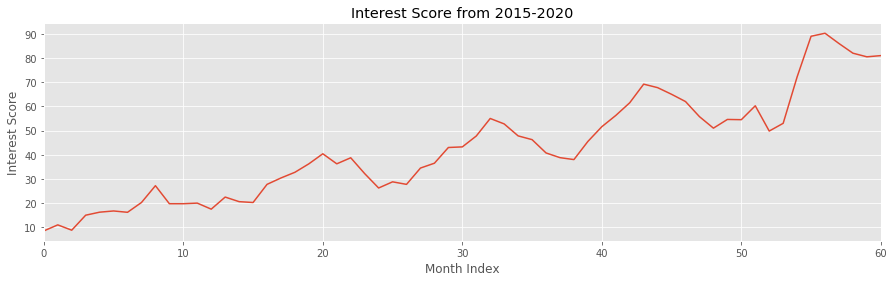

In [12]:
plt.style.use('ggplot')
monthly_data["interest_score"].plot(figsize=(15,4))
plt.title("Interest Score from 2015-2020")
plt.ylabel("Interest Score")
plt.xlabel("Month Index")

## Model Fitting

Typically, I would use a traditional time series model (ARMA, ARIMA, SARIMA, etc.) or a sliding window (e.g. use the previous 5 observations to predict the next). However, since we just created features that attempt to pick up aspects of the trend in interest scores, it's reasonable to use traditional machine learning algorithms to learn the pattern and try to predict the future. So, I will fit the following models to forecast future interest scores: Linear Regression (OLS), random forest, Gradient Boosting Machine (GBM). These three are commonly used models for regression problems and have different degrees of complexity. With the OLS and random forest models, we can get a sense of feature importance, while GBM's tend to perform well in prediction problems.

To evaluate model performance, I will split the dataset into a training set (75% of data) and test set (25% of data), fit the models on the training set, and compare how each model performed on the test set using RMSE. RMSE gives a relatively higher weight to large errors compared to MAE (another commonly used metric for regression problems), which is good since we prefer to avoid large errors. 

For the random forest and GBM models, I will use 5-fold cross validation across the parameter space to tune the models.

In [13]:
## create dummy variables
dummy_vars = pd.get_dummies(monthly_data.loc[:,"season"], prefix= "season", prefix_sep='_')
X = pd.concat([monthly_data.drop(["season", "interest_score"], axis=1), dummy_vars], axis = 1)
Y = monthly_data["interest_score"]

## split data into test and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

## function to compute the rmse
def compute_rmse(predictions, yvalues):
    return np.sqrt(sum((np.array(predictions)-np.array(yvalues))**2)/len(yvalues))

In [14]:
## OLS model

OLS = LinearRegression()
OLS.fit(X_train, Y_train)
ols_preds = OLS.predict(X_test)
print(f"RMSE for OLS: {compute_rmse(ols_preds, Y_test)}")

RMSE for OLS: 8.613624593367188


In [15]:
## random forest model

## initialize the model and parameter space and find optimal hyperparameters
rf_model = RandomForestRegressor(random_state = 100, max_features = 'sqrt')
parameters = {'n_estimators': np.arange(30, 301, 30)}

rf_gridcv = GridSearchCV(estimator = rf_model, param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')
rf_gridcv.fit(X_train, Y_train)
print(rf_gridcv.best_params_)
print(rf_gridcv.best_score_)

{'n_estimators': 300}
-68.13492108950598


In [16]:
mod = RandomForestRegressor(n_estimators = 30, random_state = 100)
mod.fit(X_train, Y_train)
rf_preds = mod.predict(X_test)
print(f"RMSE for Random Forest: {compute_rmse(rf_preds, Y_test)}")

RMSE for Random Forest: 8.205166309506879


In [17]:
## GBM model

## intialize parameter space and find optimal hyperparameters
rates = [.01, .1, .25, .5, .75, 1]
ntrees = [x for x in np.arange(100, 501, 100)]

gb_model = GradientBoostingRegressor(random_state = 100)
parameters = {'learning_rate': rates,
              'n_estimators': ntrees}


gbm_gridcv = GridSearchCV(estimator = gb_model, param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')

gbm_gridcv.fit(X_train, Y_train)

print(gbm_gridcv.best_params_)
print(gbm_gridcv.best_score_)

{'learning_rate': 0.1, 'n_estimators': 100}
-31.9564296720632


In [18]:
gb_model = GradientBoostingRegressor(learning_rate = .1, n_estimators = 100, random_state = 100)
gb_model.fit(X_train, Y_train)
gbm_preds = gb_model.predict(X_test)
print(f"RMSE for GBM: {compute_rmse(gbm_preds, Y_test)}")

RMSE for GBM: 7.388339983438476


## Model Evaluation and Prediction

Here is how the models performed, using RMSE as the metric:

1. Linear Regression: 8.61
2. Random Forest: 8.21
3. Gradient Boosting Machine: 7.39


So, I will use the GBM model, which had a RMSE of 7.39, to predict "roof near me" interest scores for the next 12 months.

In [19]:
## generate data frame for next 12 months
year = [2020] + [2021]*11
month = [12] + [x for x in range(1,12)]
pandemic = [1]*12
season = ["winter"]*3 + ["spring"]*3 + ["summer"]*3 + ["fall"]*3

mapping = {"year": year, "month": month, "during_pandemic": pandemic, "season": season}
next_year = pd.DataFrame(data = mapping)
next_year["may_to_oct"] = next_year["month"].apply(lambda x: may_to_oct(x))

dummy_vars = pd.get_dummies(next_year.loc[:,"season"], prefix= "season", prefix_sep='_')
next_year = pd.concat([next_year.drop(["season"], axis=1), dummy_vars], axis = 1)

Text(0.5, 0, 'Month Index')

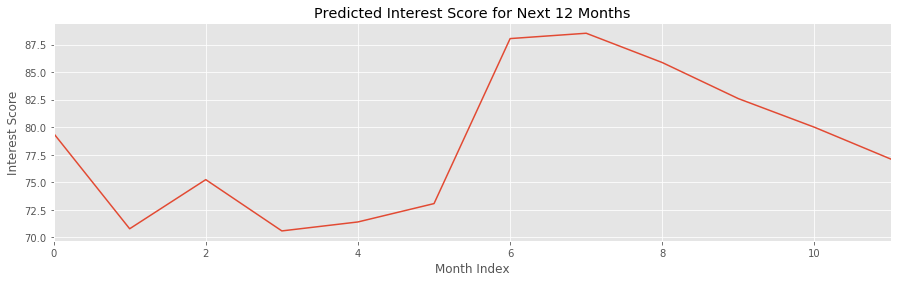

In [20]:
## make prediction for next 12 months
predictions = gb_model.predict(next_year)

pd.Series(predictions).plot(figsize=(15,4))
plt.title("Predicted Interest Score for Next 12 Months")
plt.ylabel("Interest Score")
plt.xlabel("Month Index")

In [21]:
## output predictions
pd.DataFrame(data = {"year": year, "month": month, "prediction": predictions})

,year,month,prediction
0,2020,12,79.436652
1,2021,1,70.771492
2,2021,2,75.232229
3,2021,3,70.575873
4,2021,4,71.390019
5,2021,5,73.057479
6,2021,6,88.039568
7,2021,7,88.524808
8,2021,8,85.862441
9,2021,9,82.586747


## Business Case Applications

Here are a few departments that could find this model useful:

1. Marketing/Sales: For a group of regions of interest (ex. New York, Dallas), re-fit the model for each region to find the months with the highest interest above a certain threshold (ex. interest score > 55). Then, the marketing department can target marketing campaigns to those regions during the months of highest interest, and the sales department can target customers in a similar manner.       
<br />
2. Supply chain: use the model to forecast demand for the near future to optimize supply chain performance. For example, if we know there's going to be significant demand in September 2021 but not much in November 2021, we can adjust supply of raw materials accordingly to minimize surplus.   
<br />
3. Customer Service: use the model to forecast interest, and restructure department such that the number of full-time customer service representatives is sufficient to cover inquiries during the months with normal forecasted interest, and hire temporary staff for the months with higher forecasted interest, saving costs in the long run.   
<br />
4. Logistics: Similar to customer service, we can use the forecasted interest to rent trucks and hire drivers based on demand, with a fleet of trucks and drivers large enough to cover demand during months with normal forecasted interest and hiring temporary staff and renting trucks for the months with higher forecasted demand.  
